# BE m228 Final Project

### Import Libraries

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Read in Data

In [ ]:
demographics = pd.read_csv('data/bio.csv')
demographics.head(3)

# defining if patient is diabetic, pre-diabetic, or not diabetic based on A1c levels
def diabetic_status(a1c):
    if a1c < 5.7:
        return 'Not Diabetic'
    elif 5.7 <= a1c <= 6.4:
        return 'Pre-Diabetic'
    else:
        return 'Diabetic'

demographics['Diabetic Status'] = demographics['A1c PDL (Lab)'].apply(diabetic_status)
demographics.head(3)

,subject,Age,Gender,BMI,Body weight,Height,Self-identify,A1c PDL (Lab),Fasting GLU - PDL (Lab),Insulin,...,VLDL (Cal),Cho/HDL Ratio,Collection time PDL (Lab),#1 Contour Fingerstick GLU,Time (t),#2 Contour Fingerstick GLU,Time (t).1,#3 Contour Fingerstick GLU,Time (t).2,Diabetic Status
0,1,27,M,22.265239,133.8,65.0,Hispanic/Latino,5.4,91,2.5,...,13,2.9,11:06:00 AM,89,9:40,73,12:11,81,13:18,Not Diabetic
1,2,49,F,30.946742,169.2,62.0,Hispanic/Latino,5.5,93,14.8,...,12,2.0,7:38:00 AM,91,7:52,123,9:21,80,10:22,Not Diabetic
2,3,59,F,26.948690,157.0,64.0,Hispanic/Latino,6.5,118,17.4,...,31,2.6,7:25:00 AM,119,7:38,166,9:23,98,10:23,Diabetic


In [11]:
# getting counts of each diabetic status category
diabetic_counts = demographics['Diabetic Status'].value_counts()
print(diabetic_counts)

Diabetic Status
Pre-Diabetic    16
Not Diabetic    15
Diabetic        14
Name: count, dtype: int64


### Participant One Example

In [12]:
participant_one = pd.read_csv('participants/CGMacros-001.csv')
participant_one.head(3)

,Unnamed: 0,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,Image path
0,0,2020-05-01 10:30:00,84.000000,NaN,56.0,1.0484,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-05-01 10:31:00,84.133333,NaN,56.0,1.0484,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-05-01 10:32:00,84.266667,NaN,57.0,1.0484,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


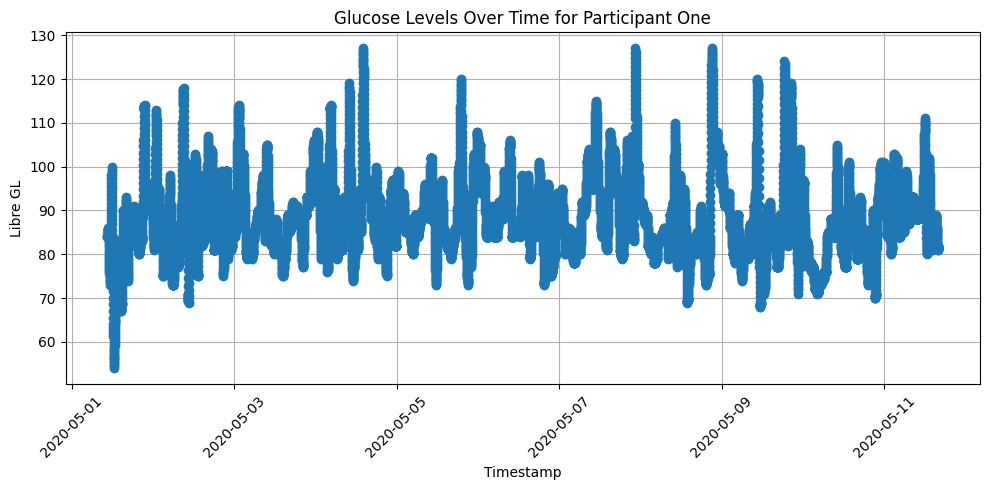

In [13]:
# transform timestamp column to datetime format
participant_one['Timestamp'] = pd.to_datetime(participant_one['Timestamp'])
# plotting glucose levels 'Libre GL' for participant_one    
plt.figure(figsize=(10, 5))
plt.plot(participant_one['Timestamp'], participant_one['Libre GL'], marker='o')
plt.title('Glucose Levels Over Time for Participant One')
plt.xlabel('Timestamp')
plt.ylabel('Libre GL')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

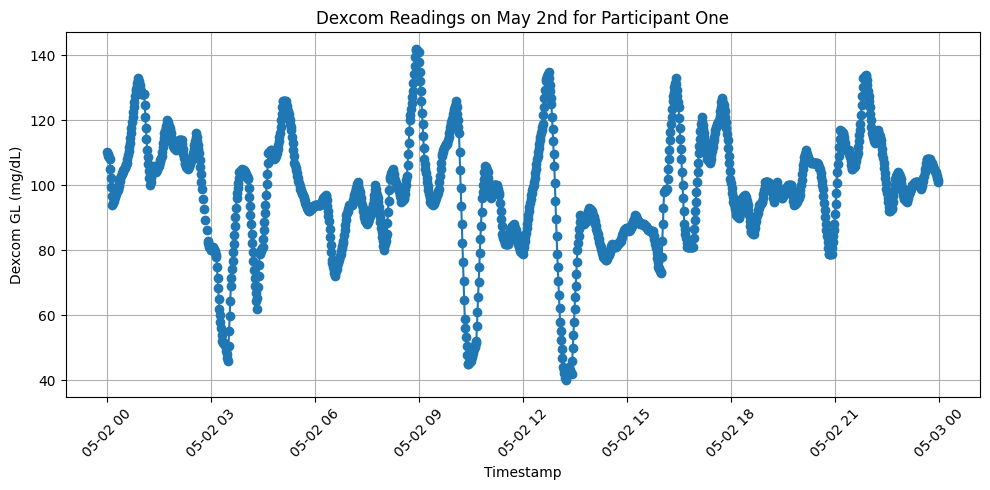

In [14]:
# plotting glucose data for participant_one only for day one (2020-05-01)
participant_one_day_one = participant_one[participant_one['Timestamp'].dt.date == pd.to_datetime('2020-05-02').date()]
plt.figure(figsize=(10, 5))
plt.plot(participant_one_day_one['Timestamp'], participant_one_day_one['Dexcom GL'], marker='o')
plt.title('Dexcom Readings on May 2nd for Participant One')
plt.xlabel('Timestamp')
plt.ylabel('Dexcom GL (mg/dL)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

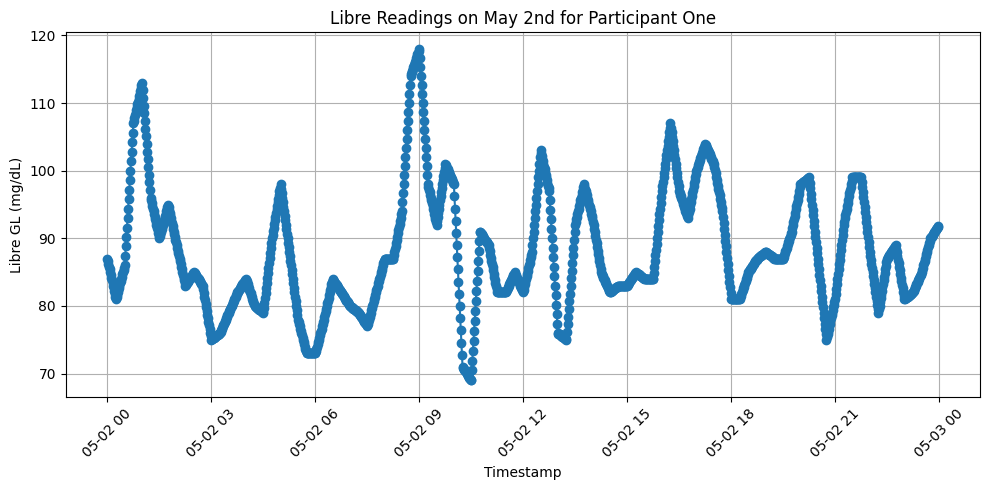

In [15]:
# plotting glucose data for participant_one only for day one (2020-05-01)
participant_one_day_one = participant_one[participant_one['Timestamp'].dt.date == pd.to_datetime('2020-05-02').date()]
plt.figure(figsize=(10, 5))
plt.plot(participant_one_day_one['Timestamp'], participant_one_day_one['Libre GL'], marker='o')
plt.title('Libre Readings on May 2nd for Participant One')
plt.xlabel('Timestamp')
plt.ylabel('Libre GL (mg/dL)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()